# Neogen Report   
#### Import required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### Data collected from the following link: https://apps.ams.usda.gov/pdp   
The data contains information of pesticides used on different commodities during the year 1994 to 2021

In [2]:
# read the data into a pandas dataframe
df = pd.read_csv('PDP Positive Detects 1994-2021.csv', low_memory=False)
df.head()

Sample ID Commod Pesticide Code  Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160    Chlorpyrifos          C   
1  CA0310280484AACA1      AA             83  O-Phenylphenol          I   
2  CA0311250391AACA1      AA             83  O-Phenylphenol          I   
3  FL0308220056AAFL1      AA            160    Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160    Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
0         0.0250  0.0040   M         C         M      NaN          M    O   
1         0.0170  0.0100   M        MO       NaN       QV          H    O   
2         0.0170  0.0100   M        MO       NaN       QV          H    O   
3         0.0063  0.0038   M       NaN       NaN       Q           M    O   
4         0.0170  0.0038   M         D       NaN      NaN          M    O   

  Extract  Determ EPA Tolerance (ppm)  
0     552     2.0                   5  
1     550     7.0                  NT  
2     550     7.0                  NT  
3     802    60.0                   5  
4     551    60.0                   5

## Preprocessing   
First we extracted the date from the the "sample ID" column which contains a unique sample identifer (combination of 2-letter Collection State code), 2-digit Year, 2-digit Month, 2-digit Day, 4-digit Collection Site code, 2-letter Commodity code, 3-character Analyzing Lab code, and optional 1-letter Source ID code   

In [3]:
# Create an empty list to store the extracted dates
dates = []

# Iterate through each row in the dataframe and extract the date from the "PDP Sample ID" column
for i in range(len(df)):
    sample_id = df.loc[i, "Sample ID"]
    year = sample_id[2:4]
    month = sample_id[4:6]
    day = sample_id[6:8]
    date = f"{year}-{month}-{day}"  # Assumes year is in the 21st century
    dates.append(date)

# Add the list of dates as a new column "Date" to the dataframe
df["Date"] = dates

More specifically we extracted the year and created a "Year" column

In [4]:
# Define a function to extract the year value from a date string and add the century prefix
def get_century_year(date_str):
    year = int(date_str[:2])
    if year > 90:
        century_prefix = "19"
    else:
        century_prefix = "20"
    return int(century_prefix + date_str[:2])

# Apply the get_century_year function to the date column to create the new "Year" column
df["Year"] = df["Date"].apply(get_century_year)

We then converted the "Concentration" column so all the units are in 'ppm' or (parts per million) so it would be accurate when compared to the EPA Tolerance column which is all in ppm

In [5]:
# Convert parts per trillion to parts per million where pp_ is 'T'
df.loc[df['pp_'] == 'T', 'Concentration'] = df['Concentration'] / 1000000
df.loc[df['pp_'] == 'T', 'LOD'] = df['LOD'] / 1000000
df.loc[df['pp_'] == 'T', 'pp_'] = 'M'

Next we excluded everything that was non-numeric in the 'EPA Tolerance (ppm)' column. Example of non-numeric data includes NT = no tolerance and AD = FDA action level

In [6]:
EPA = list(df["EPA Tolerance (ppm)"])
numbers = []
for i in EPA:
    if isinstance(i,str):
        # Find number or decimal in the column, exclude nan or otherwise:
        match = re.findall(r'\d+(?:\.\d+)?', i)
        if len(match) == 1:
            numbers.append(float(match[0]))
        elif len(match) == 2:
            numbers.append(float(match[0])/float(match[1]))
        else:
            numbers.append(np.nan)
    else:
        numbers.append(np.nan)
        
df["New EPA"] = numbers
df = df.dropna(subset=['New EPA'])

## Analysis   
Now that the preprocessing is finished, we then created a 'Percent of Threshold' column which compares the concentration to the EPA threshold. This helps us identify hazardous pesticides that exceeds the threshhold (higher that 100% means the concentration is greater than the EPA treshold).

In [7]:
df['Percent of Threshold'] = (df['Concentration'] / df['New EPA']) * 100
df.head()

Sample ID Commod Pesticide Code Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160   Chlorpyrifos          C   
3  FL0308220056AAFL1      AA            160   Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160   Chlorpyrifos          C   
5  NY0307300009AAFL1      AA            160   Chlorpyrifos          C   
6  NY0307300228AAFL1      AA            160   Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
0         0.0250  0.0040   M         C         M      NaN          M    O   
3         0.0063  0.0038   M       NaN       NaN       Q           M    O   
4         0.0170  0.0038   M         D       NaN      NaN          M    O   
5         0.0063  0.0038   M         D       NaN        Q          M    O   
6         0.0063  0.0038   M         D       NaN        Q          M    O   

  Extract  Determ EPA Tolerance (ppm)      Date  Year  New EPA  \
0     552     2.0                   5  03-07-28  2003      5.0   
3     802    60.0                   5  03-08-22  2003      5.0   
4     551    60.0                   5  03-07-28  2003      5.0   
5     551     2.0                   5  03-07-30  2003      5.0   
6     551     2.0                   5  03-07-30  2003      5.0   

   Percent of Threshold  
0                 0.500  
3                 0.126  
4                 0.340  
5                 0.126  
6                 0.126

Next, we created a new table that groups the data by pesticide & year, and calculates the mean of the Percent of Threshold column. By doing so, we can compare the average harmfulness of each pesticide instead of pesticide/commodity

In [12]:
# Group the data by pesticide and year, and calculate the mean of the Percent of Threshold column
df_grouped = df.groupby(['Pesticide Name', 'Year'])['Percent of Threshold'].mean().reset_index()

# Print the new table
df_grouped.head()

Pesticide Name  Year  Percent of Threshold
0     1-Naphthol  1996              1.175000
1     1-Naphthol  1997              1.185417
2     1-Naphthol  1998              0.561333
3     1-Naphthol  1999              0.250000
4     1-Naphthol  2000              0.250000

We filtered out all of the pesticides that does not include a complete data between the years 1994 to 2021.

In [29]:
# Create a pivot table with years as columns and pesticides as index
df_pivot = df_grouped.pivot(index='Pesticide Name', columns='Year', values='Percent of Threshold')

# Find pesticides with complete data between 1994 and 2021
complete_data_pesticides = df_pivot.dropna(axis=0).index

# Filter the original grouped dataframe to only include the pesticides with complete data
df_filtered = df_grouped[df_grouped['Pesticide Name'].isin(complete_data_pesticides)]

# Print the filtered dataframe
df_filtered.tail()

Pesticide Name  Year  Percent of Threshold
3120  Thiabendazole  2017              1.642795
3121  Thiabendazole  2018              3.494410
3122  Thiabendazole  2019              1.810577
3123  Thiabendazole  2020              1.485794
3124  Thiabendazole  2021              2.739748

## Future Prediction   
Using the new table we performed a double exponential smotthing method to forecast the 'Percent of Threshold' for the next 5 years (2022 to 2026)

In [30]:
# Initialize an empty DataFrame to store the forecasts
df_forecast = pd.DataFrame(columns=['Pesticide Name', 'Year', 'Predicted Percent of Threshold'])

# Iterate through each unique pesticide in df_filtered
for pesticide in df_filtered['Pesticide Name'].unique():
    # Filter the data for the current pesticide
    df_pesticide = df_filtered[df_filtered['Pesticide Name'] == pesticide].sort_values(by='Year')

    # Perform double exponential smoothing
    model = ExponentialSmoothing(df_pesticide['Percent of Threshold'], trend='add', seasonal=None)
    model_fit = model.fit()

    # Forecast the 'Percent of Threshold' for the next 5 years
    forecast = model_fit.forecast(steps=5)

    # Create a new DataFrame with the forecasted data
    years_to_predict = range(df_pesticide['Year'].max() + 1, df_pesticide['Year'].max() + 6)
    df_pred = pd.DataFrame({'Pesticide Name': [pesticide] * 5, 'Year': years_to_predict, 'Predicted Percent of Threshold': forecast})

    # Append the forecasted data to the df_forecast DataFrame
    df_forecast = df_forecast.append(df_pred, ignore_index=True)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarni

## Graph   
Finaly we graphed the pesticides by using the predicted percent of threshold

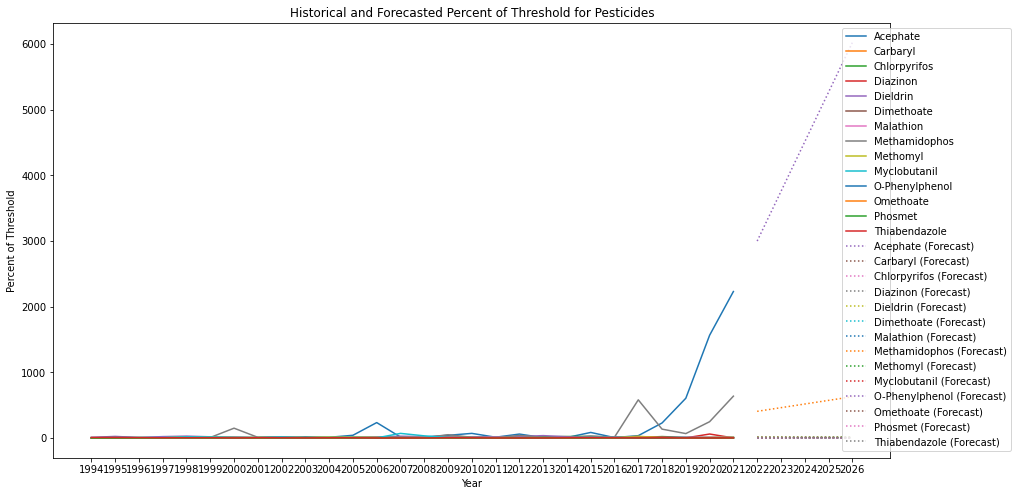

In [20]:
import matplotlib.pyplot as plt

# ... (continue from your existing code)

# Initialize the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the historical data as solid lines
for pesticide in df_filtered['Pesticide Name'].unique():
    df_pesticide = df_filtered[df_filtered['Pesticide Name'] == pesticide].sort_values(by='Year')
    ax.plot(df_pesticide['Year'], df_pesticide['Percent of Threshold'], label=pesticide, linestyle='-')

# Plot the forecasted data as dotted lines
for pesticide in df_forecast['Pesticide Name'].unique():
    df_pred = df_forecast[df_forecast['Pesticide Name'] == pesticide].sort_values(by='Year')
    ax.plot(df_pred['Year'], df_pred['Predicted Percent of Threshold'], label=pesticide + ' (Forecast)', linestyle=':')

# Customize the plot
ax.set_xlabel('Year')
ax.set_ylabel('Percent of Threshold')
ax.set_title('Historical and Forecasted Percent of Threshold for Pesticides')
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(range(1994, df_forecast['Year'].max() + 1))
plt.show()

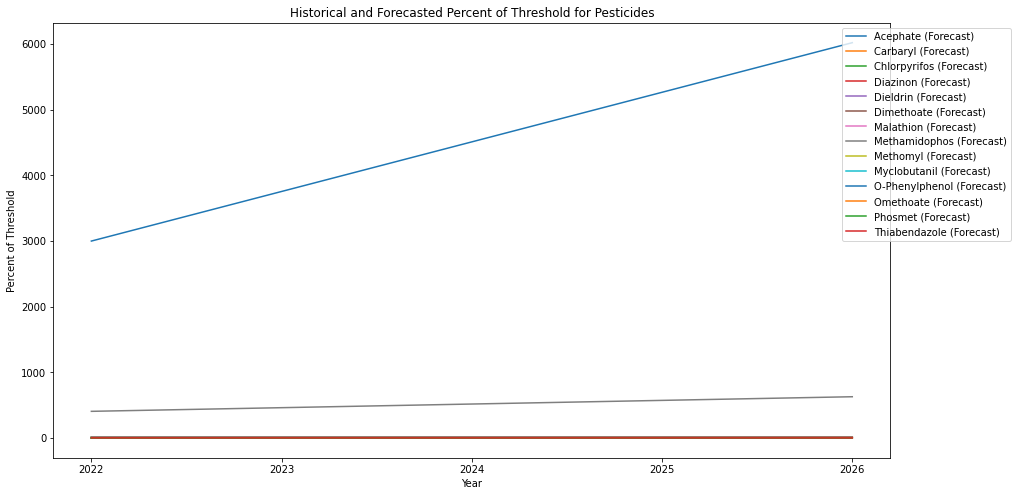

In [25]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the forecasted data as dotted lines
for pesticide in df_forecast['Pesticide Name'].unique():
    df_pred = df_forecast[df_forecast['Pesticide Name'] == pesticide].sort_values(by='Year')
    ax.plot(df_pred['Year'], df_pred['Predicted Percent of Threshold'], label=pesticide + ' (Forecast)', linestyle='-')

# Customize the plot
ax.set_xlabel('Year')
ax.set_ylabel('Percent of Threshold')
ax.set_title('Historical and Forecasted Percent of Threshold for Pesticides')
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(range(2022, df_forecast['Year'].max() + 1))
plt.show()

As we can see in the graph, the pesticide with the biggest impact on human and animal health in the next 5 years will be Acephate and Methamidophos as the percent of threshold is predicted to be the highest and incresing the most reapidly compared to the other pesticides